# Revert Rate

We'll do this the same way as we did for NEWTEA and NEWTEA Revisited, with a zero/one-inflated beta model in `brms`

In [1]:
library(tidyverse)
library(broom)

#library(brms) # install.packages("brms")
#library(loo) # install.packages("loo")
#library(rstanarm) # install.packages("rstanarm")

library(lubridate)
library(bayesplot)

library(lme4)
library(yardstick) # install.packages("yardstick")

library(caret)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


This is bayesplot version 1.7.2

- Online documentation and vignettes at mc-stan.org/bayesplot

- bayesplot theme set to bayesplot::theme_default()

   * Does _not_ affect other ggplot2 plots

   * See ?bayesplot_theme_set for details on theme setting

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


For binary classification, the first factor level is assumed to be the event.
Use the 

# R Configuration variables

In [2]:
## NOTE: `loo`, which we use for model comparisons, has a tendency to use lots or run out of memory.
## Therefore, I've often had to set mc.cores to 1 before running it. However, if we set its `pointwise`
## parameter, it'll use less memory. And it'll use BLAS, so we restrict the number of BLAS threads to 1.
## Then mc.cores controls the number of parallel processes.

## blas_set_num_threads() also controls the number of threads that glmer() uses. Depending on the load
## on the server at the time we're doing our analysis we can tune the number of threads.

library(RhpcBLASctl)
blas_set_num_threads(1)
options(mc.cores = 4, digits = 3, scipen = 500)

# Give me wider plots, please
options(repr.plot.width = 14, repr.plot.height = 7)

# Helper functions

In [3]:
## Function that takes in a model, the validation set, the name of the predicted column,
## and returns a plot of the ROC curve
plot_ROC <- function(mod, val_data, col_name) {
    val_data$estimate = predict(mod, val_data, type = "response")
    roc_curve(val_data, {{ col_name }}, estimate, event_level = 'second') %>%
        ggplot(aes(x = 1 - specificity, y = sensitivity)) +
        geom_path() +
        geom_abline(lty = 3) +
        coord_equal() +
        theme_bw()
}

In [4]:
## Function that takes in the filename of the user edit data, reads it in,
## and creates all the various derived columns we need.
read_user_dataset <- function(dataset_filename) {
    read_tsv(
        dataset_filename,
        col_types = user_dataset_column_types) %>%
    mutate(
        Group = factor(hp_enabled, levels = c(0, 1), labels = c("C", "HP")),
        platform = factor(reg_on_mobile == 1, c(FALSE, TRUE), c("desktop", "mobile")),
        ## Registration month, for later joins on month
        reg_month = floor_date(user_registration_timestamp, unit = 'month'),
        # Number of edits:
        num_total_edits_24hrs = num_article_edits_24hrs + num_other_edits_24hrs,
        num_total_edits_2w = num_article_edits_2w + num_other_edits_2w,
        num_total_edits = num_total_edits_24hrs + num_total_edits_2w,
        num_total_article_edits = num_article_edits_24hrs + num_article_edits_2w,
        num_total_other_edits = num_other_edits_24hrs + num_total_edits_2w,
        # Log number of total edits is used as a control variable in the revert analysis
        log_num_total_edits = log(1 + num_total_edits),
        # Number of reverts:
        num_reverts_24hrs = num_article_reverts_24hrs + num_other_reverts_24hrs,
        num_reverts_2w = num_article_reverts_2w + num_other_reverts_2w,
        num_total_reverts = num_reverts_24hrs + num_reverts_2w,
        ## Control variables for the number of edits made (used for ex. in revert analysis)
        log_num_article_edits_24hrs = log(1 + num_article_edits_24hrs),
        log_num_other_edits_24hrs = log(1 + num_other_edits_24hrs),
        log_num_edits_24hrs = log(1 + num_article_edits_24hrs + num_other_edits_24hrs),
        # Control variables for the number of constructive edits made
        log_num_const_article_edits_24hrs = log(
            1 + num_article_edits_24hrs - num_article_reverts_24hrs),
        log_num_const_other_edits_24hrs = log(
            1 + num_other_edits_24hrs - num_other_reverts_24hrs),
        log_num_const_edits_24hrs = log(
            1 + num_article_edits_24hrs + num_other_edits_24hrs -
                num_article_reverts_24hrs - num_other_reverts_24hrs),
        # Revert rate:
        prop_rev_edits = ifelse(num_total_edits > 0, num_total_reverts / num_total_edits, 0),
        # Did they activate?
        is_activated_article = num_article_edits_24hrs > 0,
        is_activated_other = num_other_edits_24hrs > 0,
        is_activated = is_activated_article | is_activated_other,
        # Did they activate through constructive edits?
        is_const_activated_article = (num_article_edits_24hrs - num_article_reverts_24hrs) > 0,
        is_const_activated_other = (num_other_edits_24hrs - num_other_reverts_24hrs) > 0,
        is_const_activated = is_const_activated_article | is_const_activated_other,
        # Were they retained?
        is_retained_article = is_activated_article & (num_article_edits_2w > 0),
        is_retained_other = is_activated_other & (num_other_edits_2w > 0),
        is_retained = is_activated & ((num_article_edits_2w + num_other_edits_2w) > 0),
        # Were they retained through constructive edits?
        is_const_retained_article = is_const_activated_article &
            ((num_article_edits_2w - num_article_reverts_2w) > 0),
        is_const_retained_other = is_const_activated_other &
            ((num_other_edits_2w - num_other_reverts_2w) > 0),
        is_const_retained = is_const_activated &
            ((num_article_edits_2w + num_other_edits_2w -
              num_article_reverts_2w - num_other_reverts_2w) > 0)
    ) 
}

In [5]:
## Function that takes in the filename of the active editors dataset,
## and adds a registration month column for easy joining with the user dataset.
read_active_editors_dataset <- function(dataset_filename) {
    read_tsv(
        dataset_filename,
        col_types = active_editors_column_types) %>%
    mutate(wiki_db = factor(wiki_db),
           reg_month = month + months(1))
}

# Experiment Configuration Variables

We define a set of configuration variables that are useful for the analysis. One obvious one is where the edit dataset is located.

A less obvious one is a variable for when the experiment started. We often use this seeking to model the community's initial response to changes in newcomer behaviour, as well as long-term trends in the outcome variable when working with user data gathered across a relatively long time period.

In [6]:
## Path to the datasets with user edits
user_dataset_filenames <- c(
    '/home/nettrom/src/2021-Growth-structured-tasks/datasets/add-a-link-edit-data.tsv'
    )

## Column types in the dataset: wiki is a factor, HP variant is a factor, registration is a date time,
## everything else are integers.
user_dataset_column_types <- 'fiTiifiiiiiiii'

## Path to the dataset with counts of the number of active editors
active_editors_filenames <- c()

## Column types in the active editors dataset: month is a date, wiki is a factor
active_editors_column_types <- 'Dfiii'

## Deployment timestamps for Add a Link on each of the wikis
## Note that we turn wiki_db into a factor, otherwise wiki_db in the edit dataset
## becomes a character after joining the two.
exp_start_timestamps <- tribble(
    ~wiki_db, ~exp_start_timestamp,
    'arwiki', ymd_hms('2021-05-27 19:12:03', tz = 'UTC'),
    'bnwiki', ymd_hms('2021-05-27 19:12:03', tz = 'UTC'),
    'cswiki', ymd_hms('2021-05-27 19:12:03', tz = 'UTC'),
    'viwiki', ymd_hms('2021-05-27 19:12:03', tz = 'UTC'),
    'fawiki', ymd_hms('2021-07-21 11:11:21', tz = 'UTC'),
    'frwiki', ymd_hms('2021-07-21 11:11:21', tz = 'UTC'),
    'huwiki', ymd_hms('2021-07-21 11:11:21', tz = 'UTC'),
    'plwiki', ymd_hms('2021-07-21 11:11:21', tz = 'UTC'),
    'rowiki', ymd_hms('2021-07-21 11:11:21', tz = 'UTC'),
    'ruwiki', ymd_hms('2021-07-21 11:11:21', tz = 'UTC'),

) %>% mutate(wiki_db = factor(wiki_db))

## Path to the dataset with editing status at account registration
editing_status_filenames <- c()

## Column types in the editing status dataset: wiki is a factor, everything else are integers
editing_status_column_types <- 'fii'

## Path to the dataset with Welcome Survey responses
survey_response_filenames <- c()

## Columns types in the survey response data: user ID is an integer, number of languages is a number,
## everything else are factors
survey_response_column_types <- 'fifffn'

# Data import and setup

In [7]:
user_edit_data <- map_dfr(user_dataset_filenames, read_user_dataset)

In [8]:
nrow(user_edit_data)

[1] 130179

## Time since experiment start

Join the edits data with the experiment timestamps and measure time since the start to enable controlling for that:

In [9]:
user_edit_data <- user_edit_data %>%
    inner_join(exp_start_timestamps, by = 'wiki_db') %>%
    mutate(
        # Time as a measurement since deployment
        exp_days = difftime(user_registration_timestamp, exp_start_timestamp, units = 'days'),
        ln_exp_days = ifelse(exp_days < 0, 0, log(1 + as.numeric(exp_days))),
        ln_exp_weeks = ifelse(exp_days < 0, 0, log(1 + as.numeric(exp_days)/7))
    )

In [10]:
nrow(user_edit_data)

[1] 130179

Made sure that we're not dropping any users at this stage, we're good to move forward.

## Additional variables

We've previously focused on Control vs Growth Features in our analysis. In this case we'll focus primarily on Unstructured Link Task vs Add a Link, but also check against the control group. This means we want the single variable `Group` to reflect one of three options depending on `hp_enabled` and `hp_variant`

In [11]:
user_edit_data <- user_edit_data %>%
    mutate(Group = factor(ifelse(
        hp_enabled == 0, 'Control',
        ifelse(hp_variant == 'control', 'Unstructured', 'Add-a-link')),
                          c('Control', 'Unstructured', 'Add-a-link')))

## Checking number of accounts for each wiki

We might be looking at very small wikis, in case we might want to not include them in the analysis.

In [12]:
user_edit_data %>%
    group_by(wiki_db, Group) %>%
    summarize(n = n())

`summarise()` regrouping output by 'wiki_db' (override with `.groups` argument)



wiki_db,Group,n
<fct>,<fct>,<int>
arwiki,Control,7698
arwiki,Unstructured,13426
arwiki,Add-a-link,13213
bnwiki,Control,1583
bnwiki,Unstructured,2664
bnwiki,Add-a-link,2679
cswiki,Control,787
cswiki,Unstructured,1419
cswiki,Add-a-link,1447


## Splitting into Training, Test, and Validation Datasets

Split the dataset into training, test, and validation data sets.

In [13]:
## set the random seed so train/test/validation splits can be reproduced
set.seed(42)

trainIndex <- caret::createDataPartition(user_edit_data$Group,
                                         p = .8,
                                         list = FALSE,
                                         times = 1)
user_data_train = user_edit_data[trainIndex,]
user_data_second = user_edit_data[-trainIndex,]

testIndex = caret::createDataPartition(user_data_second$Group, p = .5, list = FALSE, times = 1)

user_data_test = user_data_second[testIndex,]
user_data_validate = user_data_second[-testIndex,]

Warning message:
“The `i` argument of ``[`()` can't be a matrix as of tibble 3.0.0.
Convert to a vector.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


In [14]:
user_data_test$is_activated_fct <- factor(user_data_test$is_activated,
                                          labels = c('No', 'Yes'))
user_data_validate$is_activated_fct <- factor(user_data_validate$is_activated,
                                          labels = c('No', 'Yes'))

## Visualization of revert rates overall

This plots a histogram of revert rates for users that did not have either 0% or 100% reverts.

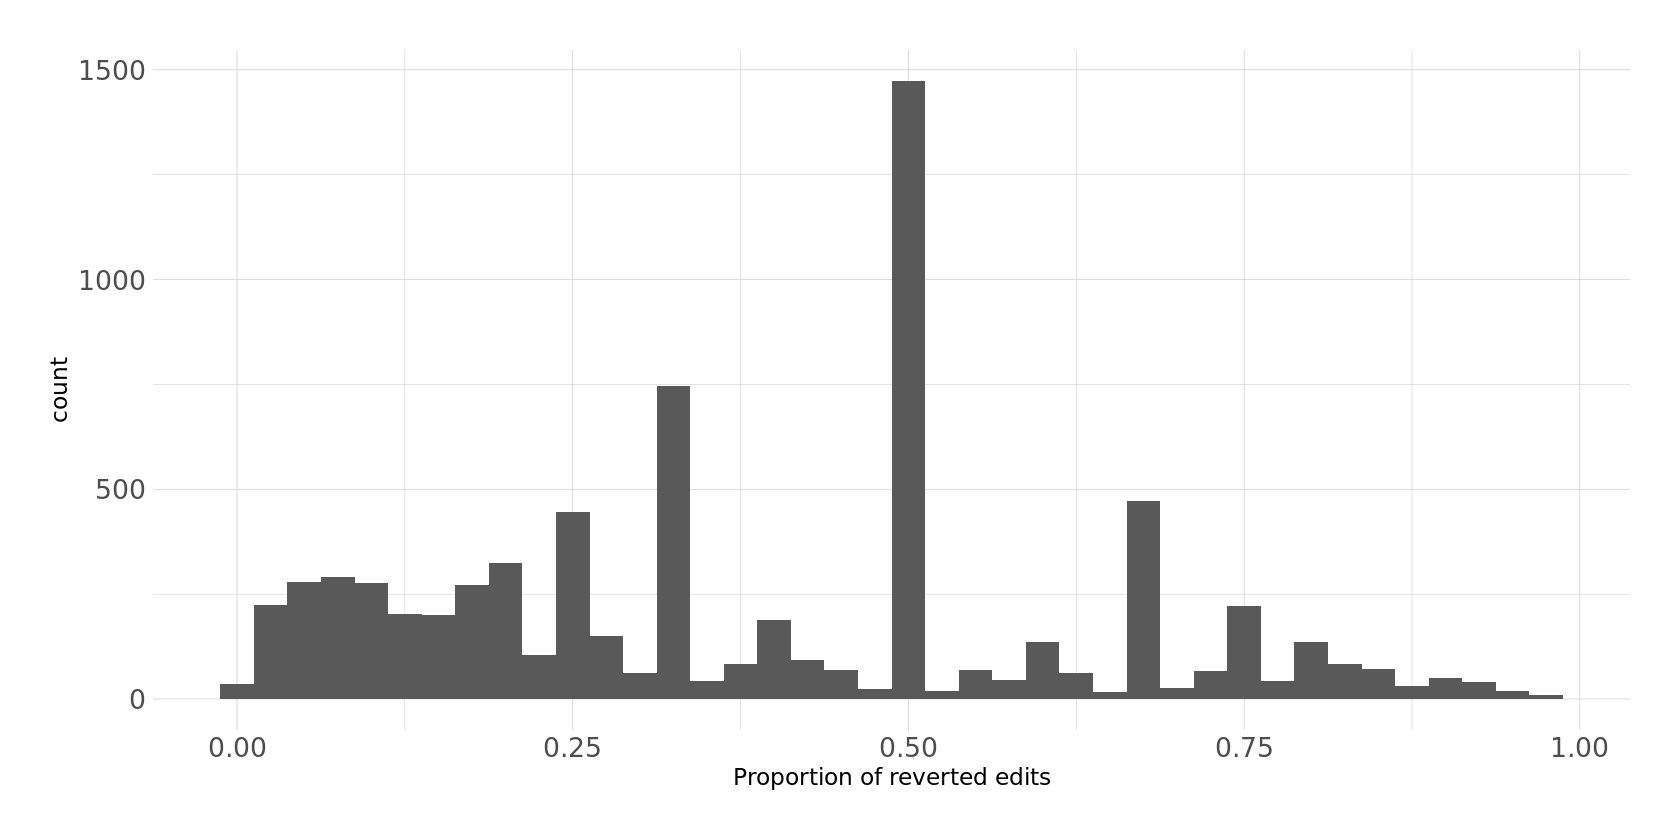

In [15]:
options(repr.plot.width = 14, repr.plot.height = 7)

user_edit_data %>%
    filter(num_total_edits > 0 & prop_rev_edits > 0 & prop_rev_edits < 1) %>%
    ggplot(aes(x = prop_rev_edits)) +
    geom_histogram(binwidth = 0.025) +
    hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold", strip_text_size = 18,
                            caption_size = 12, axis_title_size = 14, subtitle_size = 14,
                            axis_title_just = 'cm') +
    scale_x_continuous("Proportion of reverted edits")

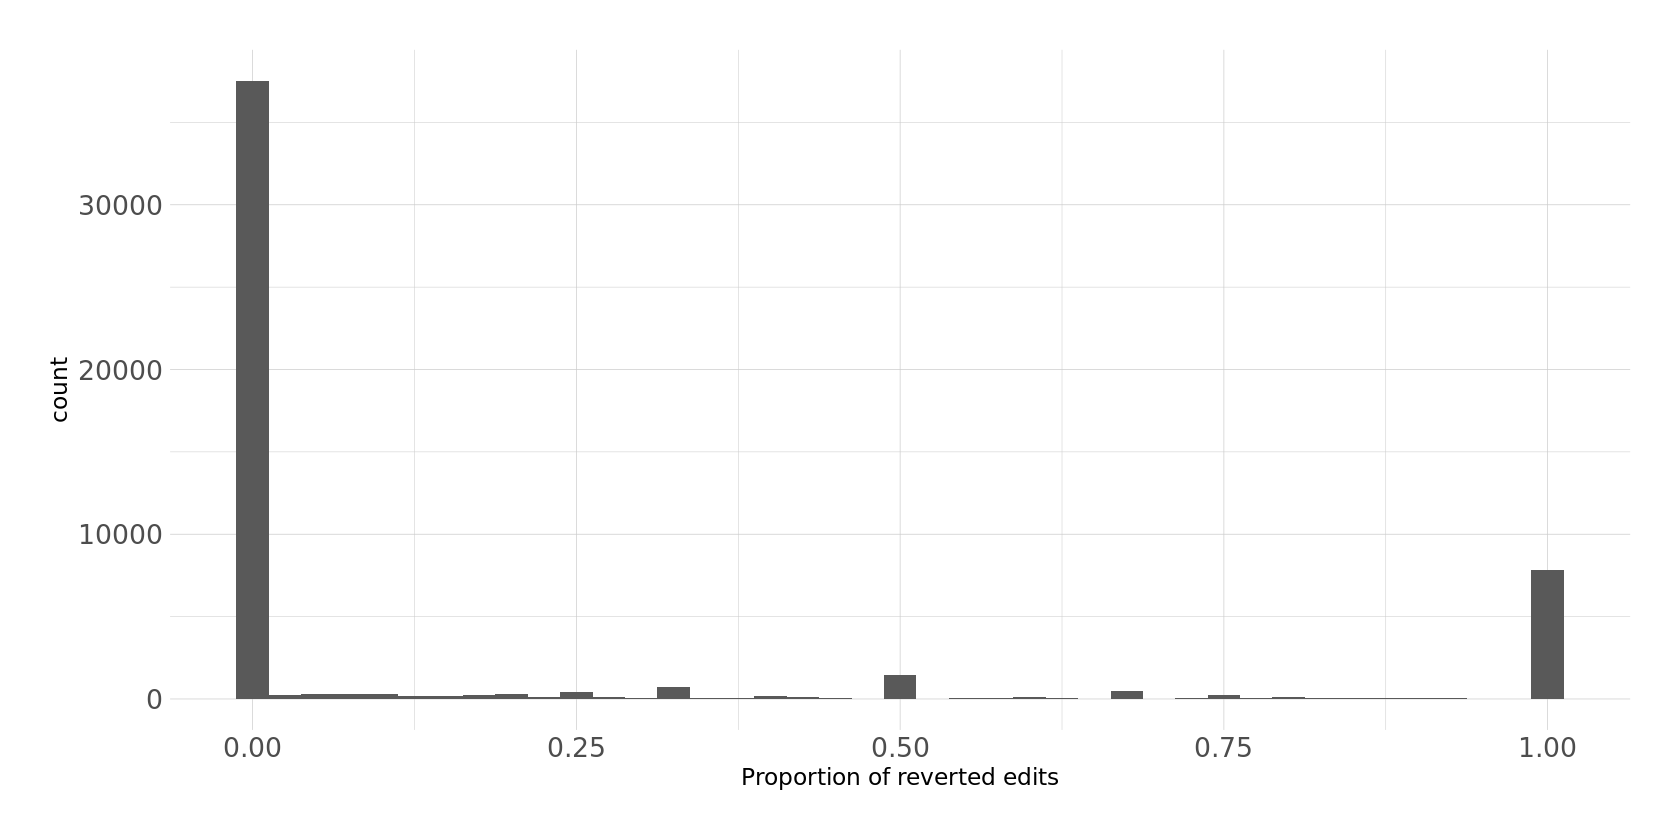

In [16]:
user_edit_data %>%
    filter(num_total_edits > 0) %>%
    ggplot(aes(x = prop_rev_edits)) +
    geom_histogram(binwidth = 0.025) +
    hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold", strip_text_size = 18,
                            caption_size = 12, axis_title_size = 14, subtitle_size = 14,
                            axis_title_just = 'cm') +
    scale_x_continuous("Proportion of reverted edits")

## Revert rate split by wiki, platform, and group

This plot needs work as we now have 27 wikis in our dataset. I've removed it for now.

In [ ]:
user_edit_data %>%
    filter(num_total_edits > 0 & prop_rev_edits > 0 & prop_rev_edits < 1) %>%
    ggplot(aes(x = prop_rev_edits)) +
    geom_histogram(binwidth = 0.025, aes(y = ..count.. / sum(..count..))) +
    facet_grid(Group ~ platform) +
    coord_cartesian(ylim = c(0, 0.02)) +
    hrbrthemes::theme_ipsum("DejaVu Sans", axis_title_just = 'cm') +
    labs(x = 'Proportion of reverted edits', y = 'Proportion of users')

In [ ]:
user_edit_data %>%
    filter(num_total_edits > 0) %>%
    ggplot(aes(x = prop_rev_edits)) +
    geom_histogram(binwidth = 0.025, aes(y = ..count.. / sum(..count..))) +
    facet_grid(Group ~ platform) +
    coord_cartesian(ylim = c(0, 0.02)) +
    hrbrthemes::theme_ipsum("DejaVu Sans", axis_title_just = 'cm') +
    labs(x = 'Proportion of reverted edits', y = 'Proportion of users')

## Homepage only

Without controlling for other factors, does the Homepage appear to have an overall effect on revert rate?

In [ ]:
zoib_formula.1 <- bf(
  prop_rev_edits ~ Group,
  phi ~ Group,
  zoi ~ Group,
  coi ~ Group, 
  family = zero_one_inflated_beta()
)

In [ ]:
zoib_model.1 <- user_edit_data %>%
    filter(num_total_edits > 0) %>%
    brm(
      formula = zoib_formula.1
    )

In [ ]:
## save the model for reference
save(zoib_model.1, file='../models/revert_rate_zoib_model.1.Robj')

Model summary:

In [ ]:
summary(zoib_model.1)

## Distribution by number of edits

We examine whether there's a difference in the distribution of revert proportion by number of edits. Since the variable is skewed, we use a log scale for this. Handily, we already have variables for this in our dataset, and look mainly at the `log_num_total_edits` variable.

In [15]:
user_edit_data <- user_edit_data %>%
    mutate(log_num_total_edits = log(1 + num_total_edits))

In [18]:
summary(user_edit_data$log_num_total_edits)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    0.00    0.00    0.50    0.69    6.72 

Make buckets based on the number of edits by flooring the log count.

In [17]:
user_edit_data$num_total_edits_bucket = floor(user_edit_data$log_num_total_edits)

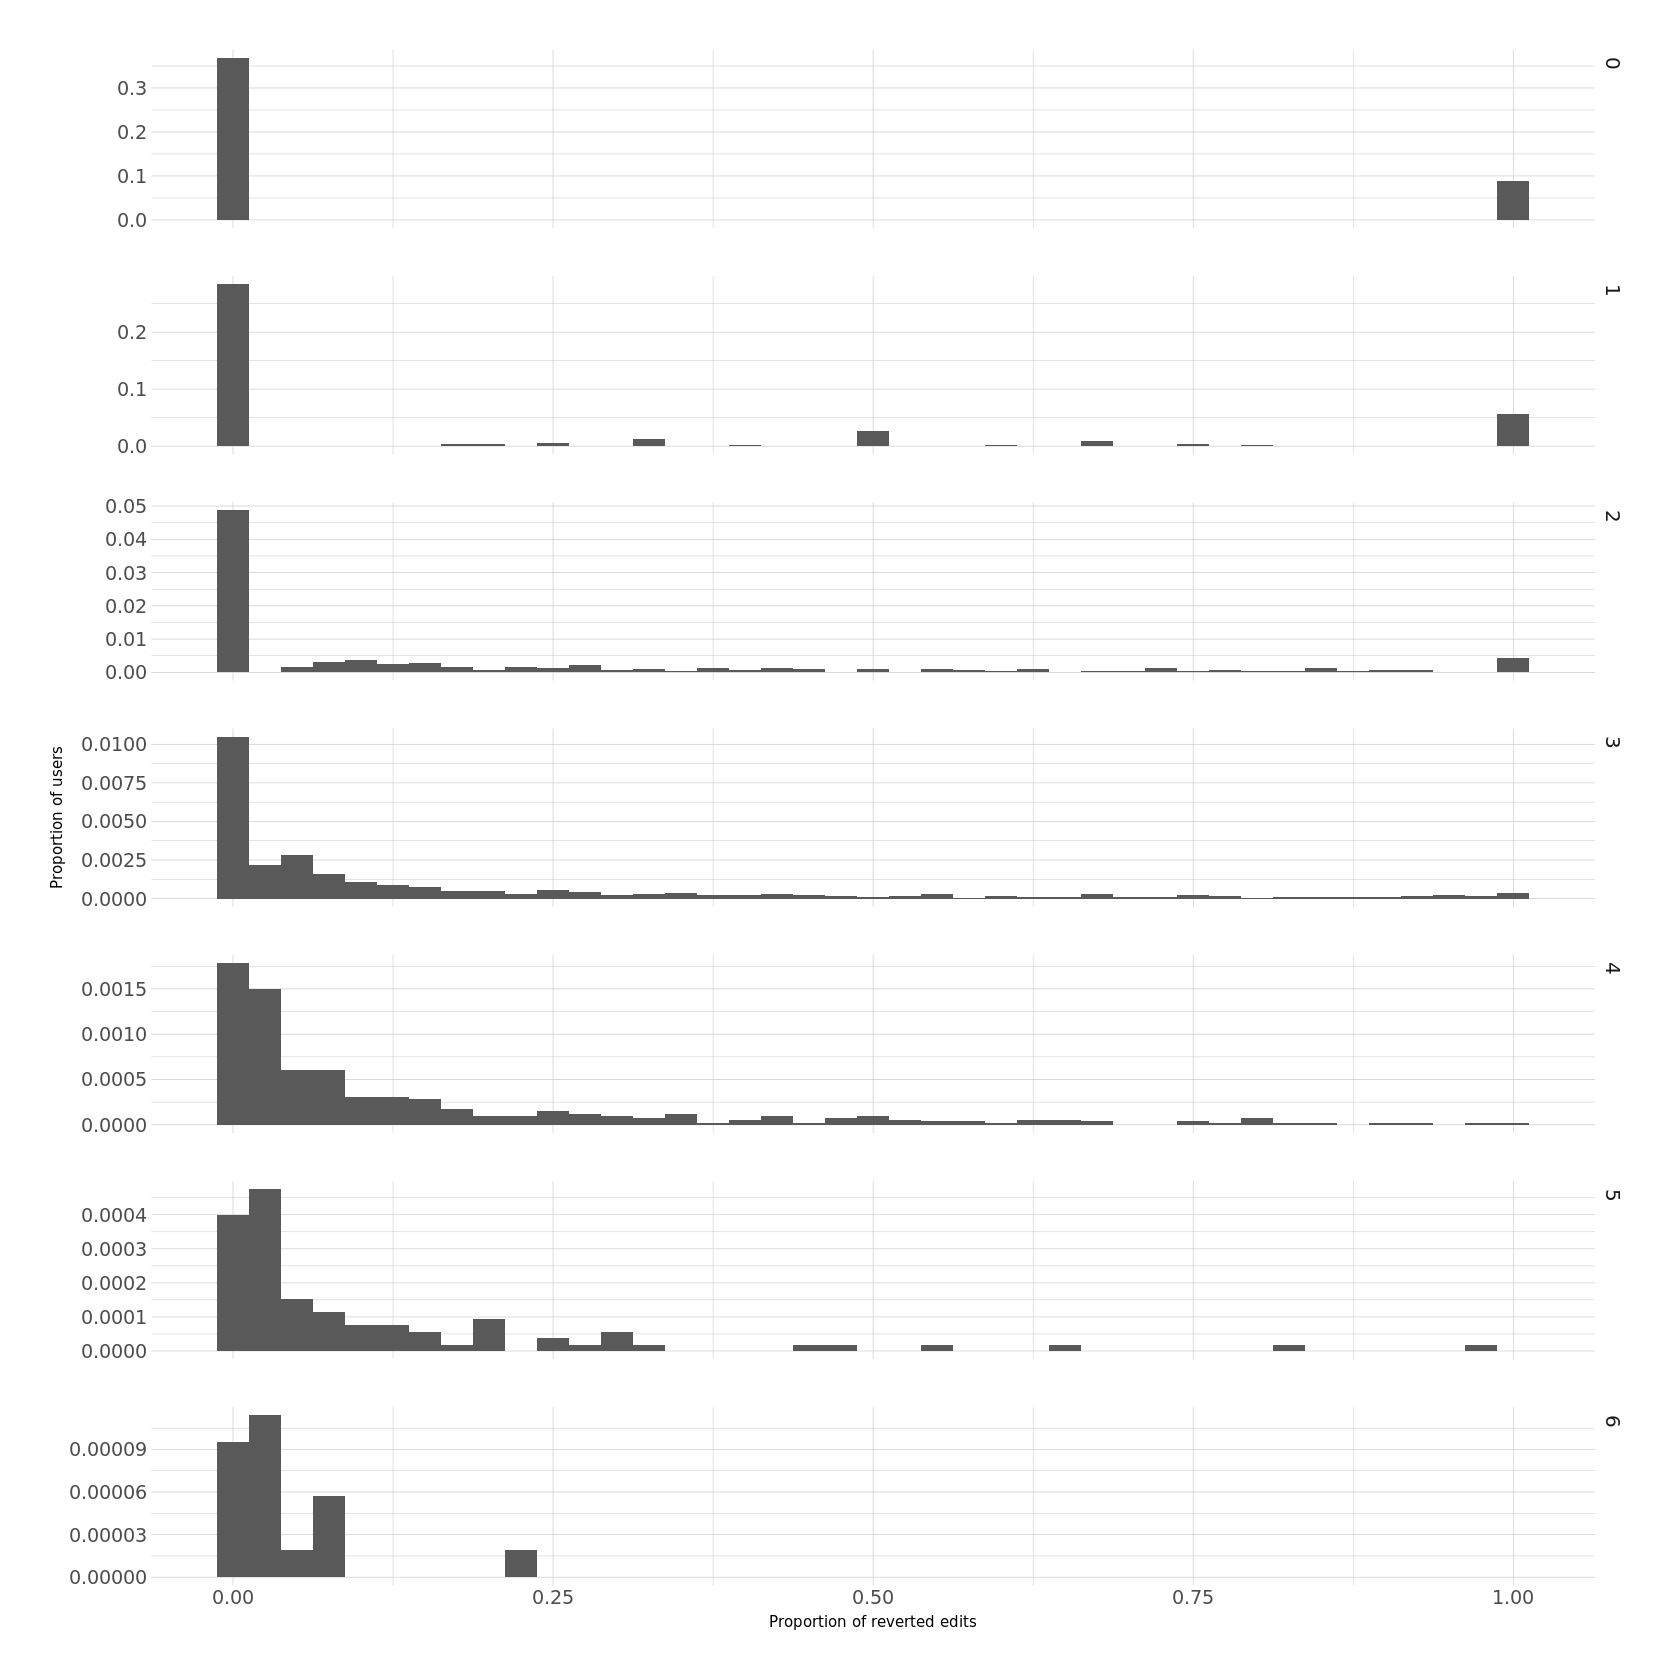

In [20]:
options(repr.plot.width = 14, repr.plot.height = 14)
user_edit_data %>%
    filter(num_total_edits > 0) %>%
    ggplot(aes(x = prop_rev_edits)) +
    geom_histogram(binwidth = 0.025, aes(y=..count../sum(..count..))) +
    hrbrthemes::theme_ipsum("DejaVu Sans", axis_title_just = 'cm') +
    labs(x = 'Proportion of reverted edits', y = 'Proportion of users') +
    facet_grid(num_total_edits_bucket ~ ., scales = "free_y")

In [16]:
user_edit_data <- user_edit_data %>%
    mutate(log2_num_total_edits = log2(num_total_edits))

Make buckets based on the number of edits by flooring the log count.

In [17]:
user_edit_data$num_total_edits_bucket_log2 = floor(user_edit_data$log2_num_total_edits)

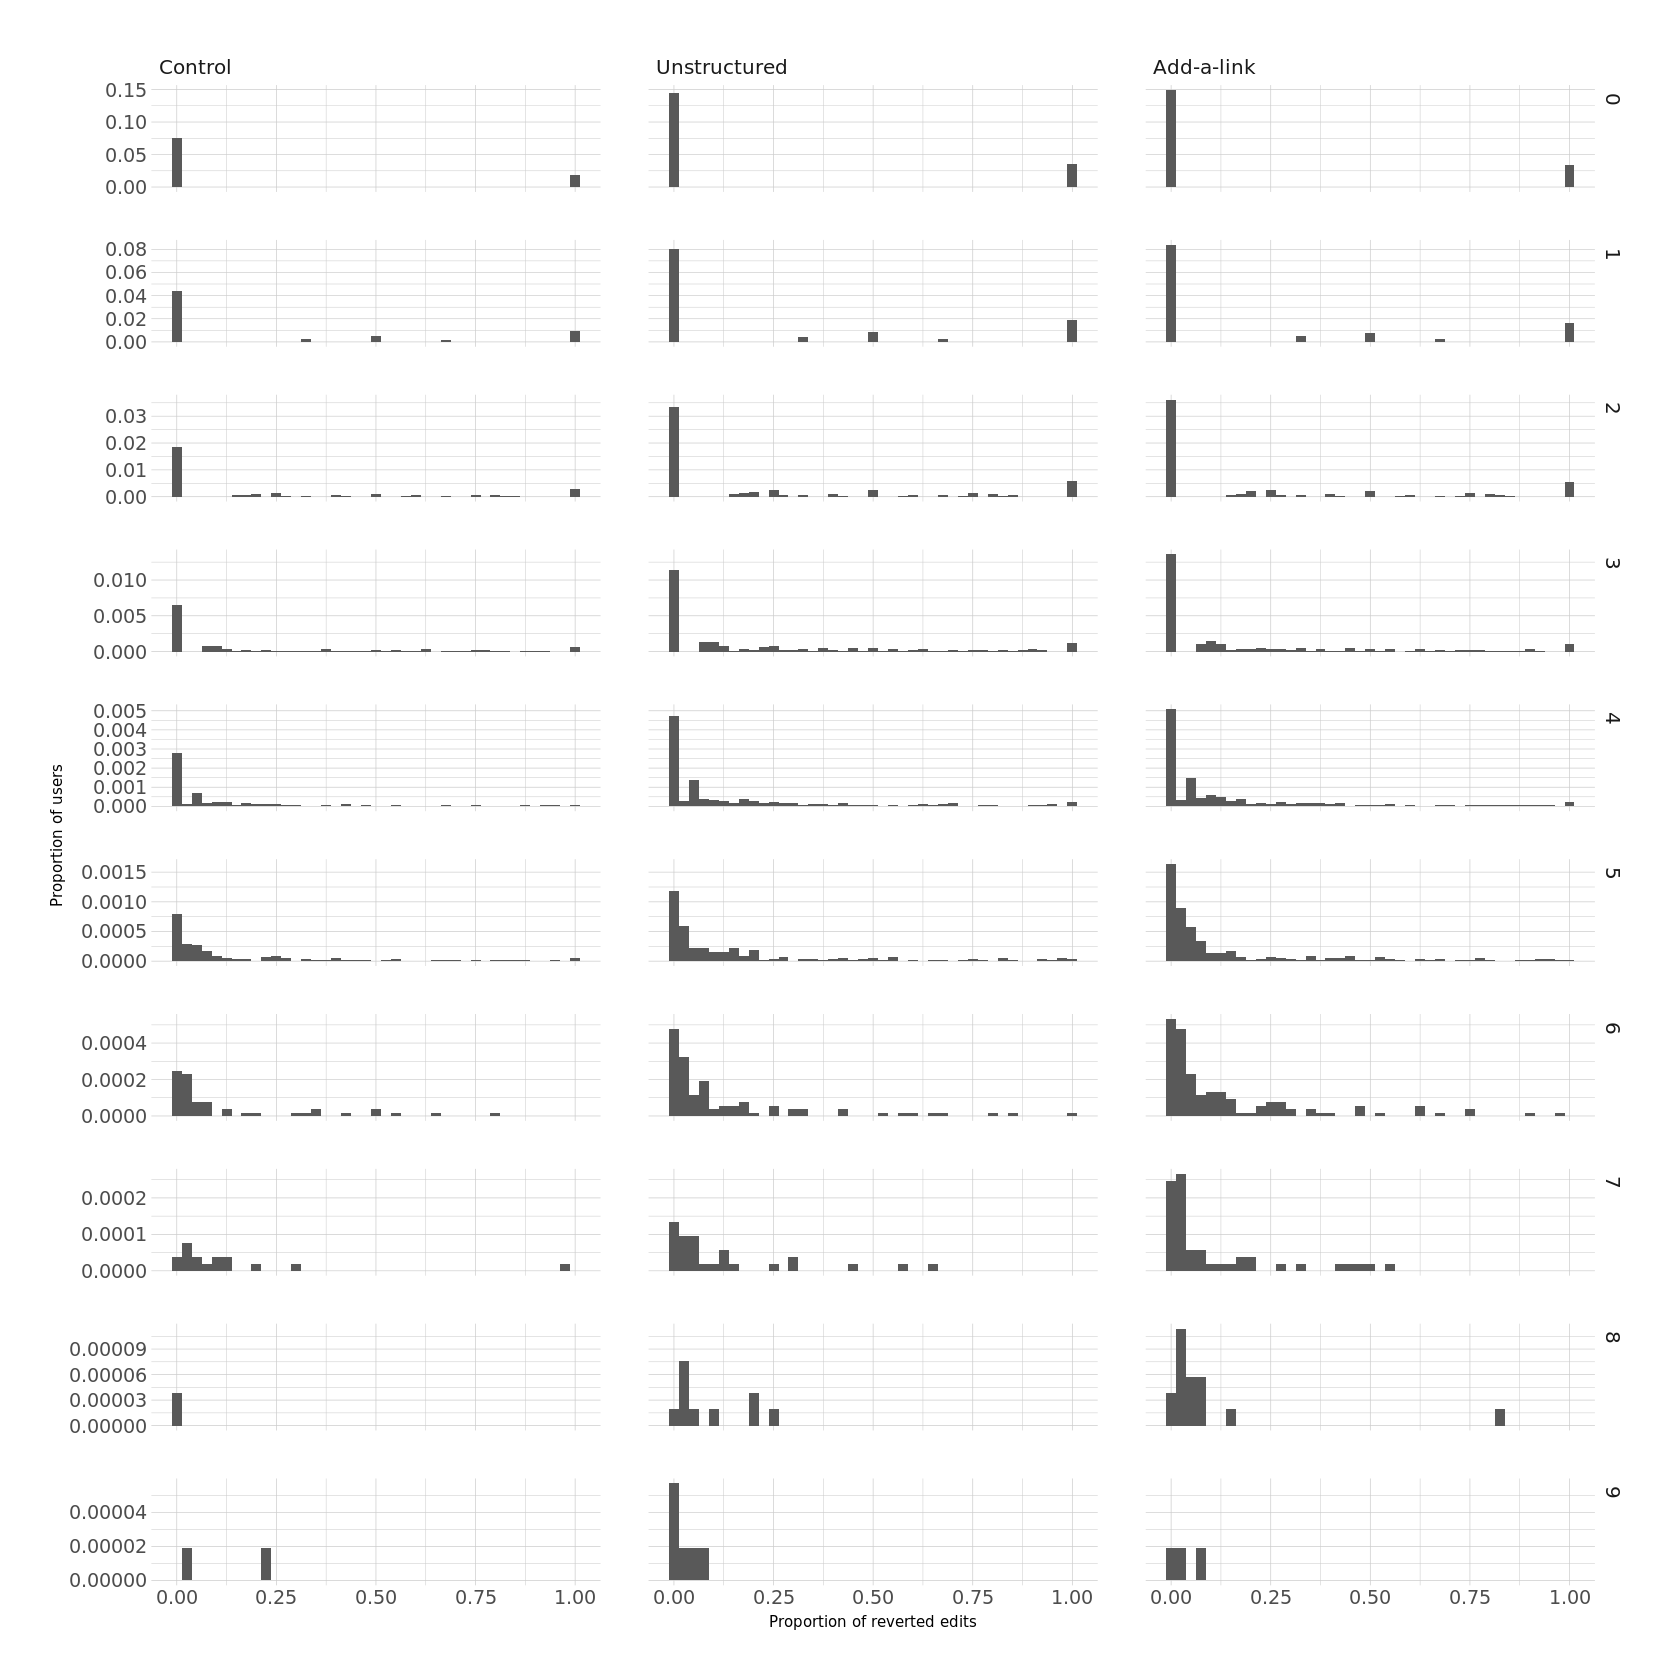

In [22]:
options(repr.plot.width = 14, repr.plot.height = 14)
user_edit_data %>%
    filter(num_total_edits > 0) %>%
    ggplot(aes(x = prop_rev_edits)) +
    geom_histogram(binwidth = 0.025, aes(y=..count../sum(..count..))) +
    hrbrthemes::theme_ipsum("DejaVu Sans", axis_title_just = 'cm') +
    labs(x = 'Proportion of reverted edits', y = 'Proportion of users') +
    facet_grid(num_total_edits_bucket_log2 ~ Group, scales = "free_y")

It's not a problem that the Y-axis isn't the same for each plot, because we're interested in understanding how the distribution changes based on edit count. What we can see is that the mean and precision of the beta distribution changes by edit count. Secondly, the probability of zero-or-one and the conditional probability of ones also changes. This suggests that we should incorporate number of edits into all four estimates in the model.

## Full Model

We reuse Model 6 from NEWTEA, because it used a hierarchical model rather than interaction between wiki and platform. Whenever we have a fairly large number of wikis (e.g. more than 3–4), that's definitely preferable. We'll continue to focus on the article namespace first, because that's where we've seen the most promising results.

In [19]:
user_edit_data <- user_edit_data %>%
    mutate(prop_rev_article_edits = ifelse(
        num_total_article_edits > 0, 
        (num_article_reverts_24hrs + num_article_reverts_2w) / num_total_article_edits, 0),
          log_num_total_article_edits = log(1 + num_total_article_edits))

In [22]:
zoib_formula.6 <- bf(
  prop_rev_article_edits ~ Group + log_num_total_article_edits + platform + (1 + platform | wiki_db),
  phi ~ Group + log_num_total_article_edits + platform + (1 + platform | wiki_db) ,
  zoi ~ Group + log_num_total_article_edits + platform + (1 + platform | wiki_db),
  coi ~ Group + log_num_total_article_edits + platform + (1 + platform | wiki_db),
  family = zero_one_inflated_beta()
)

In [ ]:
zoib_model.6 <- user_edit_data %>%
    filter(num_total_article_edits > 0) %>%
    brm(
        formula = zoib_formula.6,
        control = list(adapt_delta = 0.95,
                 max_treedepth = 15)
    )

Compiling Stan program...

Start sampling



In [ ]:
## Save the model
save(zoib_model.6, file='../models/revisited_zoib_model.6.Robj')

Model summary:

In [28]:
summary(zoib_model.6)

Warning message:
“There were 1 divergent transitions after warmup. Increasing adapt_delta above 0.95 may help. See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”


 Family: zero_one_inflated_beta 
  Links: mu = logit; phi = log; zoi = logit; coi = logit 
Formula: prop_rev_article_edits ~ Group + log_num_total_article_edits + platform + (1 + platform | wiki_db) 
         phi ~ Group + log_num_total_article_edits + platform + (1 + platform | wiki_db)
         zoi ~ Group + log_num_total_article_edits + platform + (1 + platform | wiki_db)
         coi ~ Group + log_num_total_article_edits + platform + (1 + platform | wiki_db)
   Data: . (Number of observations: 40501) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Group-Level Effects: 
~wiki_db (Number of levels: 10) 
                                      Estimate Est.Error l-95% CI u-95% CI Rhat
sd(Intercept)                             0.11      0.05     0.04     0.23 1.00
sd(platformmobile)                        0.15      0.08     0.03     0.34 1.00
sd(phi_Intercept)                         0.03      0.03     0.00     0.10 1.00
sd(phi

**NEXT UP:**

* Interpret the overall results.
* Use RStudio to interpret the model, since the output of `ranef()` and `coef()` is messed up in the notebook.
* Consider whether we should test interaction effects, or check for per-wiki variation.
  * Based on the overall statistics by platform, the reduction in revert rate on mobile is much larger in both relative and absolute terms. Therefore, testing `Group * platform` as a next step sounds very reasonable.

## Overview Statistics

For the draft report, we gather a few statistics to get a sense of the revert rate per group. Based on the results for mobile registrations (higher revert rates), we should split this by platform.

In [20]:
# Aggregate by platform and calculate average revert rate for users who edited
rate.platform.agg <- user_edit_data %>%
    filter(num_total_article_edits > 0) %>%
    group_by(platform, Group) %>%
    summarize(n = n(), mean_prop_rev_article_edits = mean(prop_rev_article_edits),
              mean_perc_rev_article_edits_rounded = round(100.0 * mean(prop_rev_article_edits), 1),
              .groups = 'keep') %>%
    group_by(platform, Group)
rate.platform.agg

platform,Group,n,mean_prop_rev_article_edits,mean_perc_rev_article_edits_rounded
<fct>,<fct>,<int>,<dbl>,<dbl>
desktop,Control,4318,0.193,19.3
desktop,Unstructured,8761,0.193,19.3
desktop,Add-a-link,9027,0.181,18.1
mobile,Control,3695,0.355,35.5
mobile,Unstructured,7095,0.362,36.2
mobile,Add-a-link,7605,0.306,30.6


In [32]:
## Calculate increase in percent
round(100.0 * (rate.platform.agg[2, "mean_prop_rev_article_edits"] -
      rate.platform.agg[1, "mean_prop_rev_article_edits"]), 1)

mean_prop_rev_article_edits
<dbl>
0


In [33]:
## Calculate increase in percent
round(100.0 * (rate.platform.agg[3, "mean_prop_rev_article_edits"] -
      rate.platform.agg[1, "mean_prop_rev_article_edits"]), 1)

mean_prop_rev_article_edits
<dbl>
-1.2


In [34]:
## Calculate increase in percent
round(100.0 * (rate.platform.agg[3, "mean_prop_rev_article_edits"] -
               rate.platform.agg[1, "mean_prop_rev_article_edits"]) /
        rate.platform.agg[1,"mean_prop_rev_article_edits"], 1)

mean_prop_rev_article_edits
<dbl>
-6.3


In [36]:
## Calculate increase in percent
round(100.0 * (rate.platform.agg[5, "mean_prop_rev_article_edits"] -
      rate.platform.agg[4, "mean_prop_rev_article_edits"]), 1)

mean_prop_rev_article_edits
<dbl>
0.8


In [38]:
## Calculate increase in percent
round(100.0 * (rate.platform.agg[5, "mean_prop_rev_article_edits"] -
               rate.platform.agg[4, "mean_prop_rev_article_edits"]) /
        rate.platform.agg[4,"mean_prop_rev_article_edits"], 1)

mean_prop_rev_article_edits
<dbl>
2.2


In [37]:
## Calculate increase in percent
round(100.0 * (rate.platform.agg[6, "mean_prop_rev_article_edits"] -
      rate.platform.agg[4, "mean_prop_rev_article_edits"]), 1)

mean_prop_rev_article_edits
<dbl>
-4.9


In [39]:
## Calculate increase in percent
round(100.0 * (rate.platform.agg[6, "mean_prop_rev_article_edits"] -
               rate.platform.agg[4, "mean_prop_rev_article_edits"]) /
        rate.platform.agg[4,"mean_prop_rev_article_edits"], 1)

mean_prop_rev_article_edits
<dbl>
-13.7


In [24]:
# Establish three user groups based on revert rate (all, none, or some)
user_edit_data <- user_edit_data %>%
    mutate(revert_group = ifelse(
        prop_rev_article_edits == 0, 'None reverted',
        ifelse(prop_rev_article_edits == 1, 'All reverted', 'Some reverted')
        )
   )

In [41]:
# Aggregate across platform and Group and calculate
# the proportion of users with all, none, or some edits reverted.
revert.group.agg <- user_edit_data %>%
    filter(num_total_article_edits > 0) %>%
    group_by(platform, Group, revert_group) %>%
    summarize(n = n(), .groups = 'keep') %>%
    group_by(platform, Group) %>%
    mutate(perc = 100 * n / sum(n), rounded_perc = round(100 * n / sum(n), 1))
revert.group.agg

platform,Group,revert_group,n,perc,rounded_perc
<fct>,<fct>,<chr>,<int>,<dbl>,<dbl>
desktop,Control,All reverted,661,15.3,15.3
desktop,Control,None reverted,3184,73.7,73.7
desktop,Control,Some reverted,473,11.0,11.0
desktop,Unstructured,All reverted,1344,15.3,15.3
desktop,Unstructured,None reverted,6497,74.2,74.2
desktop,Unstructured,Some reverted,920,10.5,10.5
desktop,Add-a-link,All reverted,1274,14.1,14.1
desktop,Add-a-link,None reverted,6718,74.4,74.4
desktop,Add-a-link,Some reverted,1035,11.5,11.5


In [48]:
## Calculate lift
round(revert.group.agg[4, "perc"] - revert.group.agg[1, "perc"], 1)

perc
<dbl>
0


In [50]:
## Calculate lift
round(revert.group.agg[7, "perc"] - revert.group.agg[1, "perc"], 1)

perc
<dbl>
-1.2


In [51]:
## Calculate diff
round(100.0 * (revert.group.agg[7, "perc"] -
               revert.group.agg[1, "perc"]) /
        revert.group.agg[1,"perc"], 1)

perc
<dbl>
-7.8


In [54]:
## Calculate lift
round(revert.group.agg[8, "perc"] - revert.group.agg[2, "perc"], 1)

perc
<dbl>
0.7


In [55]:
## Calculate diff
round(100.0 * (revert.group.agg[8, "perc"] -
               revert.group.agg[2, "perc"]) /
        revert.group.agg[2,"perc"], 1)

perc
<dbl>
0.9


In [52]:
## Calculate lift
round(revert.group.agg[5, "perc"] - revert.group.agg[2, "perc"], 1)

perc
<dbl>
0.4


In [53]:
## Calculate diff
round(100.0 * (revert.group.agg[5, "perc"] -
               revert.group.agg[2, "perc"]) /
        revert.group.agg[2,"perc"], 1)

perc
<dbl>
0.6


In [57]:
## Calculate lift
round(revert.group.agg[6, "perc"] - revert.group.agg[3, "perc"], 1)

perc
<dbl>
-0.5


In [58]:
## Calculate diff
round(100.0 * (revert.group.agg[6, "perc"] -
               revert.group.agg[3, "perc"]) /
        revert.group.agg[3,"perc"], 1)

perc
<dbl>
-4.1


In [59]:
## Calculate lift
round(revert.group.agg[9, "perc"] - revert.group.agg[3, "perc"], 1)

perc
<dbl>
0.5


In [60]:
## Calculate diff
round(100.0 * (revert.group.agg[9, "perc"] -
               revert.group.agg[3, "perc"]) /
        revert.group.agg[3,"perc"], 1)

perc
<dbl>
4.7


In [61]:
## Calculate lift
round(revert.group.agg[13, "perc"] - revert.group.agg[10, "perc"], 1)

perc
<dbl>
0.3


In [62]:
## Calculate diff
round(100.0 * (revert.group.agg[13, "perc"] -
               revert.group.agg[10, "perc"]) /
        revert.group.agg[10,"perc"], 1)

perc
<dbl>
0.9


In [63]:
## Calculate lift
round(revert.group.agg[16, "perc"] - revert.group.agg[10, "perc"], 1)

perc
<dbl>
-4.8


In [64]:
## Calculate diff
round(100.0 * (revert.group.agg[16, "perc"] -
               revert.group.agg[10, "perc"]) /
        revert.group.agg[10,"perc"], 1)

perc
<dbl>
-16.2


In [65]:
## Calculate lift
round(revert.group.agg[14, "perc"] - revert.group.agg[11, "perc"], 1)

perc
<dbl>
-1.4


In [66]:
## Calculate diff
round(100.0 * (revert.group.agg[14, "perc"] -
               revert.group.agg[11, "perc"]) /
        revert.group.agg[11,"perc"], 1)

perc
<dbl>
-2.5


In [67]:
## Calculate lift
round(revert.group.agg[17, "perc"] - revert.group.agg[11, "perc"], 1)

perc
<dbl>
4.2


In [68]:
## Calculate diff
round(100.0 * (revert.group.agg[17, "perc"] -
               revert.group.agg[11, "perc"]) /
        revert.group.agg[11,"perc"], 1)

perc
<dbl>
7.4


In [69]:
## Calculate lift
round(revert.group.agg[15, "perc"] - revert.group.agg[12, "perc"], 1)

perc
<dbl>
1.2


In [70]:
## Calculate diff
round(100.0 * (revert.group.agg[15, "perc"] -
               revert.group.agg[12, "perc"]) /
        revert.group.agg[12,"perc"], 1)

perc
<dbl>
8.3


In [71]:
## Calculate lift
round(revert.group.agg[18, "perc"] - revert.group.agg[12, "perc"], 1)

perc
<dbl>
0.6


In [72]:
## Calculate diff
round(100.0 * (revert.group.agg[18, "perc"] -
               revert.group.agg[12, "perc"]) /
        revert.group.agg[12,"perc"], 1)

perc
<dbl>
4


In [42]:
# For the "some reverted" group, calculate the mean revert proportion per group
some_reverted.platform.agg <- user_edit_data %>%
    filter(num_total_article_edits > 0 & revert_group == 'Some reverted') %>%
    group_by(platform, Group) %>%
    summarize(n = n(), mean_prop_rev_article_edits = mean(prop_rev_article_edits),
              mean_perc_rev_article_edits_rounded = round(100.0 * mean(prop_rev_article_edits), 1),
              .groups = 'keep') %>%
    group_by(platform, Group)
some_reverted.platform.agg

platform,Group,n,mean_prop_rev_article_edits,mean_perc_rev_article_edits_rounded
<fct>,<fct>,<int>,<dbl>,<dbl>
desktop,Control,473,0.363,36.3
desktop,Unstructured,920,0.379,37.9
desktop,Add-a-link,1035,0.345,34.5
mobile,Control,512,0.434,43.4
mobile,Unstructured,1065,0.435,43.5
mobile,Add-a-link,1096,0.412,41.2


In [74]:
## Calculate lift
round(100.0 * (some_reverted.platform.agg[2, "mean_prop_rev_article_edits"] -
      some_reverted.platform.agg[1, "mean_prop_rev_article_edits"]), 1)

mean_prop_rev_article_edits
<dbl>
1.6


In [76]:
## Calculate diff in percent
round(100.0 * (some_reverted.platform.agg[2, "mean_prop_rev_article_edits"] -
               some_reverted.platform.agg[1, "mean_prop_rev_article_edits"]) /
        some_reverted.platform.agg[1,"mean_prop_rev_article_edits"], 1)

mean_prop_rev_article_edits
<dbl>
4.3


In [77]:
## Calculate lift
round(100.0 * (some_reverted.platform.agg[3, "mean_prop_rev_article_edits"] -
      some_reverted.platform.agg[1, "mean_prop_rev_article_edits"]), 1)

mean_prop_rev_article_edits
<dbl>
-1.8


In [78]:
## Calculate increase in percent
round(100.0 * (some_reverted.platform.agg[3, "mean_prop_rev_article_edits"] -
               some_reverted.platform.agg[1, "mean_prop_rev_article_edits"]) /
        some_reverted.platform.agg[1,"mean_prop_rev_article_edits"], 1)

mean_prop_rev_article_edits
<dbl>
-5


In [79]:
## Calculate lift
round(100.0 * (some_reverted.platform.agg[5, "mean_prop_rev_article_edits"] -
      some_reverted.platform.agg[4, "mean_prop_rev_article_edits"]), 1)

mean_prop_rev_article_edits
<dbl>
0


In [80]:
## Calculate increase in percent
round(100.0 * (some_reverted.platform.agg[5, "mean_prop_rev_article_edits"] -
               some_reverted.platform.agg[4, "mean_prop_rev_article_edits"]) /
        some_reverted.platform.agg[4,"mean_prop_rev_article_edits"], 1)

mean_prop_rev_article_edits
<dbl>
0.1


In [81]:
## Calculate lift
round(100.0 * (some_reverted.platform.agg[6, "mean_prop_rev_article_edits"] -
      some_reverted.platform.agg[4, "mean_prop_rev_article_edits"]), 1)

mean_prop_rev_article_edits
<dbl>
-2.3


In [82]:
## Calculate increase in percent
round(100.0 * (some_reverted.platform.agg[6, "mean_prop_rev_article_edits"] -
               some_reverted.platform.agg[4, "mean_prop_rev_article_edits"]) /
        some_reverted.platform.agg[4,"mean_prop_rev_article_edits"], 1)

mean_prop_rev_article_edits
<dbl>
-5.2


Overall revert rate by group:

In [21]:
# Aggregate by platform and calculate average revert rate for users who edited
rate.group.agg <- user_edit_data %>%
    filter(num_total_article_edits > 0) %>%
    group_by(Group) %>%
    summarize(n = n(), mean_prop_rev_article_edits = mean(prop_rev_article_edits),
              mean_perc_rev_article_edits_rounded = round(100.0 * mean(prop_rev_article_edits), 1),
              .groups = 'keep')
rate.group.agg

Group,n,mean_prop_rev_article_edits,mean_perc_rev_article_edits_rounded
<fct>,<int>,<dbl>,<dbl>
Control,8013,0.267,26.7
Unstructured,15856,0.269,26.9
Add-a-link,16632,0.238,23.8


In [22]:
## Calculate lift
round(100.0 * (rate.group.agg[2, "mean_prop_rev_article_edits"] -
      rate.group.agg[1, "mean_prop_rev_article_edits"]), 1)

mean_prop_rev_article_edits
<dbl>
0.1


In [23]:
## Calculate lift:
round(100.0 * (rate.group.agg[3, "mean_prop_rev_article_edits"] -
      rate.group.agg[1, "mean_prop_rev_article_edits"]), 1)

mean_prop_rev_article_edits
<dbl>
-2.9


In [24]:
## Calculate increase in percent
round(100.0 * (rate.group.agg[2, "mean_prop_rev_article_edits"] -
               rate.group.agg[1, "mean_prop_rev_article_edits"]) /
        rate.group.agg[1,"mean_prop_rev_article_edits"], 1)

mean_prop_rev_article_edits
<dbl>
0.5


In [25]:
## Calculate increase in percent
round(100.0 * (rate.group.agg[3, "mean_prop_rev_article_edits"] -
               rate.group.agg[1, "mean_prop_rev_article_edits"]) /
        rate.group.agg[1,"mean_prop_rev_article_edits"], 1)

mean_prop_rev_article_edits
<dbl>
-11


Lift and difference between the unstructured and structured task groups:

In [26]:
## Calculate lift:
round(100.0 * (rate.group.agg[3, "mean_prop_rev_article_edits"] -
      rate.group.agg[2, "mean_prop_rev_article_edits"]), 1)

mean_prop_rev_article_edits
<dbl>
-3.1


In [27]:
## Calculate increase in percent
round(100.0 * (rate.group.agg[3, "mean_prop_rev_article_edits"] -
               rate.group.agg[2, "mean_prop_rev_article_edits"]) /
        rate.group.agg[2,"mean_prop_rev_article_edits"], 1)

mean_prop_rev_article_edits
<dbl>
-11.5


# Graphs

## Revert Rate

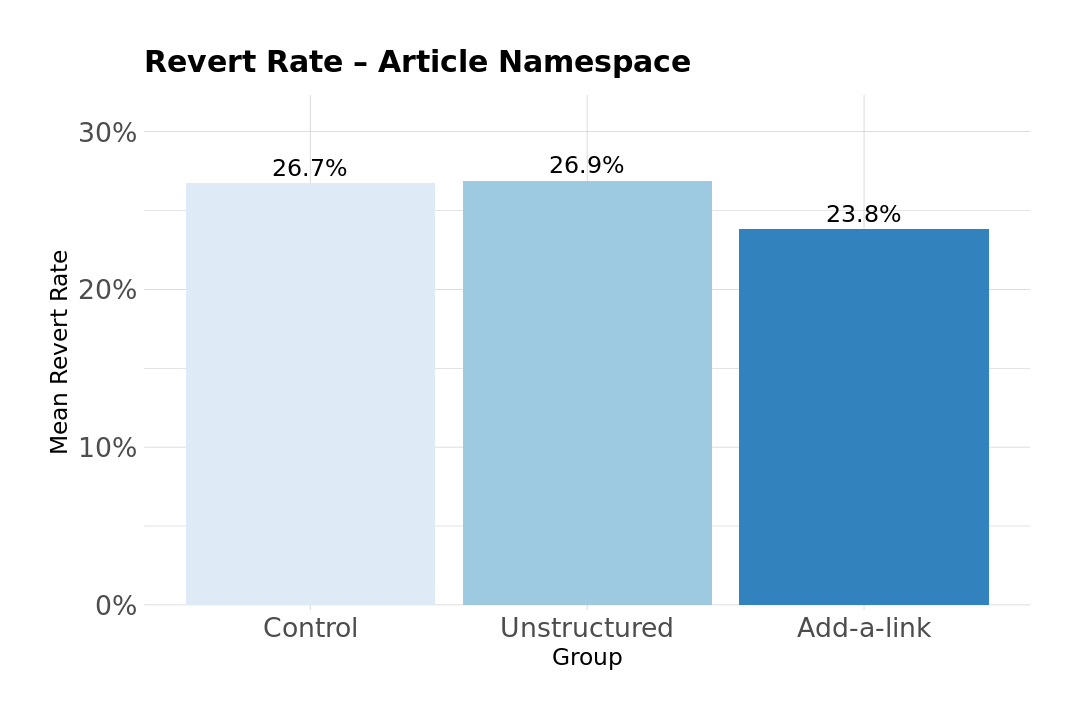

In [28]:
# Give me wider plots, please
options(repr.plot.width = 9, repr.plot.height = 6)

## Note to self: mutate() operates on a per-row basis, summarise() operates on the groups when using group_by()
rate.group.agg %>%
    ggplot(aes(x = Group, y = mean_prop_rev_article_edits, fill = Group)) +
        labs(title = 'Revert Rate – Article Namespace', x = 'Group', y = 'Mean Revert Rate') +
        hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold", strip_text_size = 18,
                            caption_size = 12, axis_title_size = 14, subtitle_size = 14,
                            axis_title_just = 'cm') +
        guides(fill = 'none') +
        scale_fill_brewer() +
        geom_col() +
        hrbrthemes::scale_y_percent(limits = c(0, 0.32)) +
        geom_text(aes(label = wmfdata::percent2(mean_prop_rev_article_edits)), nudge_y = 0.01, size = 5)
ggsave(
    'add-a-link-article-namespace-revert-rate-2021-experiment.png',
    path = 'graphs',
    width = 9, height = 6, units = "in", dpi = "screen")